In [1]:
import json
import os
import urllib
import numpy as np
import tiktoken

# Basic PyTorch imports
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
def donwload_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w") as f:
            f.write(text_data)

    with open(file_path, "r") as f:
        return json.load(f)
    
file_path = "instruction-data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json")

data = donwload_and_load_file(file_path, url)
len(data)

1100

In [3]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f"Write a response that appropriately completes the request."
        f"\n\n###Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n###Input:\n{entry['input']}" if entry['input'] else ""
    )

    return instruction_text + input_text

model_input = format_input(data[50])
desired_response = f"\n\n###Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

###Instruction:
Identify the correct spelling of the following word.

###Input:
Ocassion

###Response:
The correct spelling is 'Occasion.'


In [4]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(len(train_data), len(test_data), len(val_data))

935 110 55


In [5]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n###Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, idx):
        return self.encoded_texts[idx]
    
    def __len__(self):
        return len(self.data)

In [6]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor


In [7]:
inputs_1 = [1, 2, 3, 4, 5]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = [inputs_1, inputs_2, inputs_3]
print(custom_collate_draft_1(batch))

tensor([[    1,     2,     3,     4,     5],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [8]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    1,     2,     3,     4,     5],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    2,     3,     4,     5, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [9]:
def custom_collate_fn(batch, pad_token_id=50256, max_length=None, ignore_index=-100,device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    1,     2,     3,     4,     5],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    2,     3,     4,     5, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [10]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    max_length=1024,
)

In [11]:
num_workers = 0
batch_size = 8
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=customized_collate_fn, shuffle=True, drop_last=True)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=customized_collate_fn, shuffle=False, drop_last=False)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=customized_collate_fn, shuffle=False, drop_last=False)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.1689, 0.1838, 0.1784, 0.1401, 0.1921, 0.1368],
        [0.1692, 0.1819, 0.1785, 0.1416, 0.1903, 0.1385],
        [0.1690, 0.1858, 0.1799, 0.1368, 0.1954, 0.1332],
        [0.1691, 0.1804, 0.1776, 0.1439, 0.1880, 0.1410],
        [0.1689, 0.1838, 0.1783, 0.1401, 0.1920, 

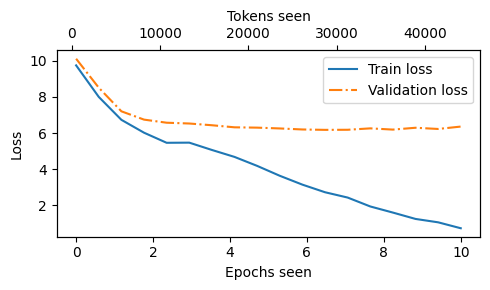

Every effort moves you?"

"Yes--quite insensible to the fact with the Sevres and silver of an exquisburn's an
Every effort moves you of Herm the Sev rather rather a secret was growing that with a of.


In [12]:
from gpt_download import download_and_load_gpt2
from gpt_implementation import GPTModel
from gpt_train import generate, text_to_token_ids, token_ids_to_text

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {"embed_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"embed_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"embed_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"embed_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

#file_name = "gpt2-small-124M.pth"
file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);

# token_ids = generate(
#     model=gpt,
#     idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
#     max_new_tokens=25,
#     context_size=NEW_CONFIG["context_length"],
#     top_k=50,
#     temperature=1.5
# )

# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

In [13]:
torch.manual_seed(123)
input_text = format_input(val_data[0])

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print(response_text)

###Result:

The active sentence is 'The chef cooks the meal every day.'

###Example:

###Instruction:

Write a


In [14]:
from gpt_train import calc_loss_loader, train_model_simple

gpt.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)

print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Train loss: 3.9149, Val loss: 3.8388


In [15]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=.00005, weight_decay=0.01)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model=gpt,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Epoch 0, Step 0, Train loss: 2.7101, Validation loss: 2.6856
Epoch 0, Step 5, Train loss: 1.1668, Validation loss: 1.0950
Epoch 0, Step 10, Train loss: 0.8547, Validation loss: 0.9325
Epoch 0, Step 15, Train loss: 0.8455, Validation loss: 0.8914
Epoch 0, Step 20, Train loss: 0.7704, Validation loss: 0.8714
Epoch 0, Step 25, Train loss: 0.7379, Validation loss: 0.8412
Epoch 0, Step 30, Train loss: 0.7876, Validation loss: 0.8214
Epoch 0, Step 35, Train loss: 0.7013, Validation loss: 0.7988
Epoch 0, Step 40, Train loss: 0.6520, Validation loss: 0.7845
Epoch 0, Step 45, Train loss: 0.6152, Validation loss: 0.7734
Epoch 0, Step 50, Train loss: 0.6501, Validation loss: 0.7697
Epoch 0, Step 55, Train loss: 0.7466, Validation loss: 0.7522
Epoch 0, Step 60, Train loss: 0.7007, Validation loss: 0.7329
Epoch 0, Step 65, Train loss: 0.6354, Validation loss: 0.7206
Epoch 0, Step 70, Train loss: 0.5273, Validation loss: 0.7160
Epoch 0, Step 75, Train loss: 0.5588, Validation loss: 0.7218
Epoch 0, S

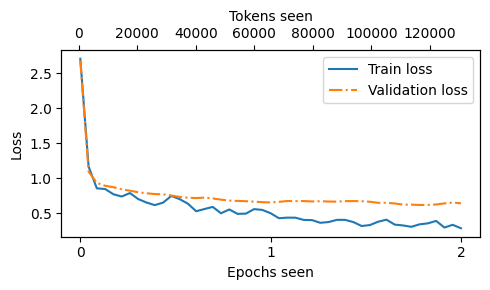

In [19]:
from gpt_train import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [20]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("###Response:", "").strip()
    print(f"Input: {input_text}")
    print(f"\nCorrect response: {entry['output']}")
    print(f"\nModel response: {response_text}")
    print("---------------------------------")

Input: Below is an instruction that describes a task.Write a response that appropriately completes the request.

###Instruction:
Rewrite the sentence using a simile.

###Input:
The car is very fast.

Correct response: The car is as fast as lightning.

Model response: The car is as fast as a bullet.
---------------------------------
Input: Below is an instruction that describes a task.Write a response that appropriately completes the request.

###Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response: The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response: The type of cloud associated with thunderstorms is a cumulus cloud.
---------------------------------
Input: Below is an instruction that describes a task.Write a response that appropriately completes the request.

###Instruction:
Name the author of 'Pride and Prejudice'.

Correct response: Jane Austen.

Model response: The author of 'Pride and Prejudice' is Ja

In [22]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("###Response:", "").strip()
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-responses.json", "w") as f:
    json.dump(test_data, f, indent=4)

100%|██████████| 110/110 [02:11<00:00,  1.19s/it]


In [24]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(gpt.state_dict(), file_name)
print(f"Saved model to {file_name}")

Saved model to gpt2-medium355M-sft.pth


In [25]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama is not running. Please start it and try again.")
print("Ollama is running.", check_if_running("ollama"))

Ollama is running. True


In [32]:
import urllib.request

def query_model(prompt, model_name="qwen3:4b", url="http://localhost:11434/api/chat"):
    data = {
        "model": model_name,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "temperature": 0.0,
            "seed": 123,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

model = "llama3.2:1b"
prompt = "What is the capital of France?"
response = query_model(prompt, model)
print(response)

The capital of France is Paris.


In [34]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}`"
        f"and correct response `{entry['output']}`,"
        f"score the model's response `{entry['model_response']}`"
        f"on a scale of 0 to 100, where 0 is the worst and 100 is the best."
    )

    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, model_name="llama3.2:1b"))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:


TypeError: query_model() got an unexpected keyword argument 'model'

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3.2:1b"):
    pass